In [2]:
import os
import os.path as op

import importlib
import numpy as np
from scipy.stats import pearsonr

import nibabel as nib
from nilearn import datasets, image

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
%matplotlib inline

from seaborn import kdeplot

import networkx as nx

import dgsp
import graph_examples as dgsp_graphs
import bimod_plots as plot

In [3]:
def plot_avg_cycle(signal, fig=None, axes=None, n_blocks=4, n_per_com=40, cmap="inferno", vmin=0, vmax=1):
    if axes is None:
        fig, axes = plt.subplots(figsize=(5, 5))

    avg_sig = signal.reshape(n_blocks, n_per_com).mean(axis=1)

    if n_blocks == 4:
        pos = np.array([[1, 1], [-1, 1], [-1, -1], [1, -1]])*0.7
        graph = np.array([[0, 1, 0, 0],
                          [0, 0, 1, 0],
                          [0, 0, 0, 1],
                          [1, 0, 0, 0]])
    else:
        raise ValueError("Only 4 blocks are supported!")
    
    graph_pos = {i: (pos[i][0], pos[i][1]) for i in range(n_blocks)}

    axes.scatter(pos[:, 0], pos[:, 1], s=1000, marker="s", c=avg_sig, cmap=cmap, vmin=vmin, vmax=vmax, edgecolor="k")
    nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes, edge_color="k", arrowsize=30,
                           min_source_margin=20, min_target_margin=20)

    axes.set_xlim(-1, 1)
    axes.set_ylim(-1, 1)

    if fig is None:
        fig = axes.get_figure()
    plot.add_cbar(fig, axes)

    return axes

In [4]:
n_samples = 10

orig_cmap = plt.get_cmap("rainbow", n_samples)
colorlist = ["k"] + [orig_cmap(i) for i in range(n_samples)]
custom_cmap = LinearSegmentedColormap.from_list("", colorlist)

exclude = [4]
cluster_colors8 = [custom_cmap.resampled(8+1)(i+1) for i in range(8) if i not in exclude]

cmap_8clusters = LinearSegmentedColormap.from_list("", ["k"] + cluster_colors8)

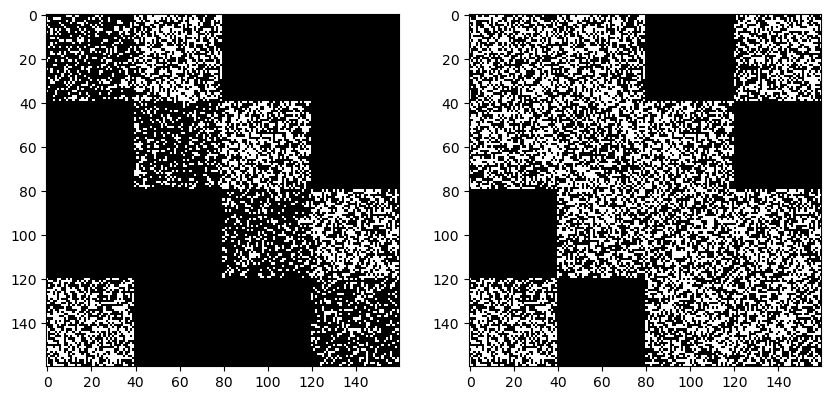

In [5]:
importlib.reload(dgsp_graphs)

adj = dgsp_graphs.block_cycle(40, n_blocks=4, com_density=0.5, connect_density=0.5)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].imshow(adj, cmap="binary_r", vmin=0, vmax=1, interpolation="none")
axes[1].imshow(adj + adj.T, cmap="binary_r", vmin=0, vmax=1, interpolation="none")

In [6]:
importlib.reload(plot)
importlib.reload(dgsp)

n_per_com = 40
density_value = .4
density_con = .4
eig_id = 0

write_s = True
for_overleaf = True
show_spectrum = False

seed = 28

density_value = .7
density_con = .2
seed = 33

write_letter = True
draw_arrow = False

# Building the graph
graph = dgsp_graphs.toy_n_communities(n_per_com, 4, com_density=density_value,
                                      connect_density=[density_con, 0, density_con, 
                                                       density_con, 0, density_con],
                                      #connect_density=[1, 1, 0, 1, 1, 1],
                                      connect_out_prob=[1, 0, 0,
                                                        1, 1, 1],
                                      seed=seed)

graph = dgsp_graphs.block_cycle(n_per_com, n_blocks=4, com_density=density_value, connect_density=density_con, seed=seed)

xt = np.zeros(len(graph))
xt[:n_per_com] += 1
# xt[:n_per_com//2] += 1
# xt[n_per_com:2*n_per_com] += 1
# xt[3*n_per_com:] += 1

# xt = np.ones(len(graph))

B = dgsp.modularity_matrix(graph)
U, S, Vh = dgsp.sorted_SVD(B)
V = Vh.T

n_nodes = len(S)
rand_pos = np.random.uniform(0.3, 1, (n_nodes, 2))

rand_pos[n_per_com:2*n_per_com, 0] *= -1
rand_pos[3*n_per_com:] *= -1
rand_pos[2*n_per_com:3*n_per_com, 1] *= -1

graph_pos = {i: (rand_pos[i, 0], rand_pos[i, 1]) for i in range(len(S))}

n_vec_max = 2
n_kmeans = 8
scale_factor = S[:n_vec_max]
edge_clusters, edge_clusters_mat = dgsp.edge_bicommunities(graph, U, V, n_vec_max, method="kmeans",
                                                           n_kmeans=n_kmeans, verbose=True, max_k=10, scale_S=scale_factor)
n_clusters = np.max(edge_clusters)
# cmap_to_use = cmap_8clusters.resampled(n_clusters+1)

c_out, c_in = dgsp.get_node_clusters(edge_clusters, edge_clusters_mat)

bimod_idx = dgsp.bimod_index_nodes(graph, c_out, c_in, scale=True)
sorting_array = np.flip(np.argsort(bimod_idx))

edge_clusters_mat_sorted = edge_clusters_mat.copy()
edge_clusters_sorted = edge_clusters.copy()
for i_new, i in enumerate(sorting_array):
    edge_clusters_mat_sorted[edge_clusters_mat == i+1] = i_new + 1
    edge_clusters_sorted[edge_clusters == i+1] = i_new + 1

edge_clusters_mat = edge_clusters_mat_sorted
edge_clusters = edge_clusters_sorted

c_out = c_out[sorting_array]
c_in = c_in[sorting_array]

C_mat_out = c_out.T/np.linalg.norm(c_out, axis=1)
c_pinv_out = np.linalg.pinv(C_mat_out)

C_mat_in = c_in.T/np.linalg.norm(c_in, axis=1)
c_pinv_in = np.linalg.pinv(C_mat_in)

Found 8 clusters !


<Axes: title={'center': 'Forward $t=12$'}>

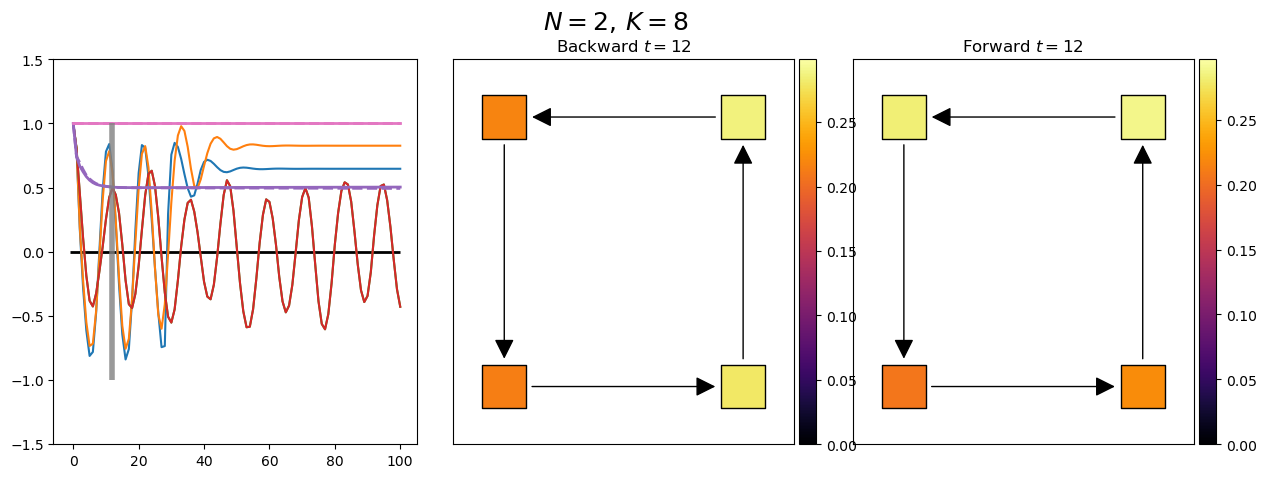

In [7]:
n_trials = 100
all_rec = np.zeros((2, n_trials+1, n_nodes))
all_rec_sing = np.zeros((2, n_trials+1, n_nodes))
all_corr = np.zeros((2, n_trials+1))
all_corr_sing = np.zeros((2, n_trials+1))

all_rec[:, 0] = np.vstack([xt]*2)
all_rec_sing[:, 0] = np.vstack([xt]*2)
all_corr[:, 0] = np.hstack([1]*2)
all_corr_sing[:, 0] = np.hstack([1]*2)

# xt = np.zeros(len(graph))
# xt[:n_per_com] += 1
# # xt[:n_per_com//2] += 1
# xt[n_per_com:2*n_per_com] += 1
# # xt[3*n_per_com:] += 1

B_norm = B / np.linalg.norm(B)
B_norm = B.copy()

for i in range(n_trials):
    coefs_in = c_pinv_in @ all_rec[0, i]
    coefs_out = c_pinv_out @ all_rec[1, i]
    
    all_rec[0, i+1] = C_mat_out @ coefs_in
    all_rec[1, i+1] = C_mat_in @ coefs_out

    all_rec_sing[0, i+1] = U @ (V.T @ all_rec_sing[0, i])
    all_rec_sing[1, i+1] = V @ (U.T @ all_rec_sing[1, i])
    
    # all_rec_sing[0, i+1] = B_norm @ all_rec_sing[0, i]
    # all_rec_sing[1, i+1] = B_norm.T @ all_rec_sing[1, i]

    all_corr[0, i+1] = pearsonr(all_rec[0, i+1], xt)[0]
    all_corr[1, i+1] = pearsonr(all_rec[1, i+1], xt)[0]
    
    all_corr_sing[0, i+1] = pearsonr(all_rec_sing[0, i+1], xt)[0]
    all_corr_sing[1, i+1] = pearsonr(all_rec_sing[1, i+1], xt)[0]

fig, axes = plt.subplots(figsize=(15, 5), ncols=3, gridspec_kw={"wspace": 0.1})

select_i = 12

fig.suptitle(f"$N={n_vec_max},\,K={n_kmeans}$", fontsize=18)
axes[0].plot(all_corr[0], zorder=1)
axes[0].plot(all_corr[1], zorder=1)

axes[0].plot(all_corr_sing[0], zorder=1)
axes[0].plot(all_corr_sing[1], zorder=1)

axes[0].plot(np.linalg.norm(all_rec[0], axis=1)/np.linalg.norm(xt), color="tab:purple", zorder=2, lw=2)
axes[0].plot(np.linalg.norm(all_rec[1], axis=1)/np.linalg.norm(xt), color="tab:purple", ls="--", zorder=2, lw=2)

axes[0].plot(np.linalg.norm(all_rec_sing[0], axis=1)/np.linalg.norm(xt), color="tab:pink", zorder=2, lw=2)
axes[0].plot(np.linalg.norm(all_rec_sing[1], axis=1)/np.linalg.norm(xt), color="tab:pink", ls="--", zorder=2, lw=2)

axes[0].hlines(0, -1, n_trials, color="k", lw=2, zorder=0)
axes[0].vlines(select_i, -1, 1, color="gray", lw=4, zorder=3, alpha=0.8)

axes[0].set_ylim(-1.5, 1.5)

axes[1].set_title(f"Backward $t={select_i}$")
plot_avg_cycle(all_rec[0, select_i], axes=axes[1], vmax=all_rec[0, select_i].max())

axes[2].set_title(f"Forward $t={select_i}$")
plot_avg_cycle(all_rec[1, select_i], axes=axes[2], vmax=all_rec[1, select_i].max())

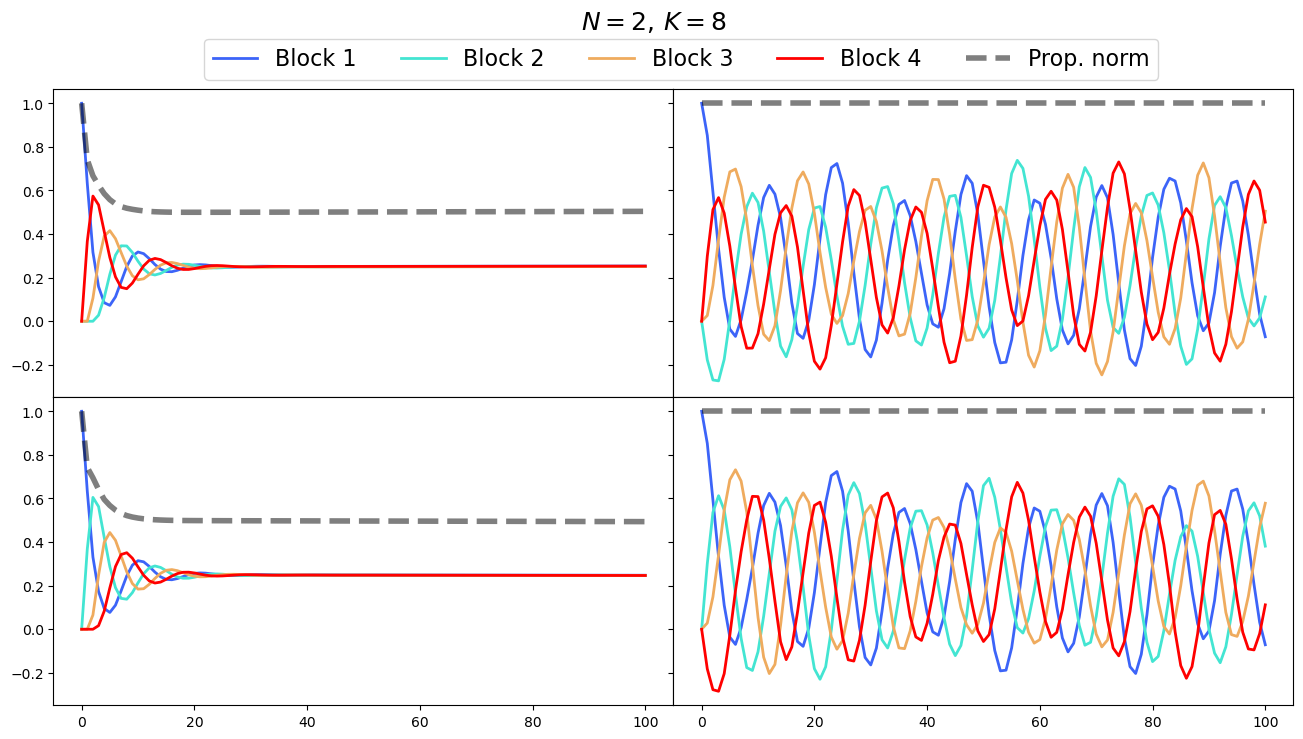

In [8]:
fig, all_axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), sharey=True,
                             gridspec_kw={"hspace": 0, "wspace": 0})

fig.suptitle(f"$N={n_vec_max},\,K={n_kmeans}$", fontsize=18)

cmap = cmap_8clusters.resampled(4+1)

# all_axes[0, 1].set_yticks([])
# all_axes[1, 1].set_yticks([])

for axes, rec_type in zip(all_axes.T, [all_rec, all_rec_sing]):
    for ax_i, rec in enumerate(rec_type):
        for i, avg_sig in enumerate(rec.reshape((-1, 4, n_per_com)).mean(axis=2).T):
            axes[ax_i].plot(avg_sig, lw=2, color=cmap(i+1), label=f"Block {i+1}")

        axes[ax_i].plot(np.linalg.norm(rec, axis=1)/np.linalg.norm(xt), ls="--", lw=4, alpha=0.5, color="k", label="Prop. norm")

axes[0].legend(ncols=5, bbox_to_anchor=[0.8, 1.2], fontsize=16)

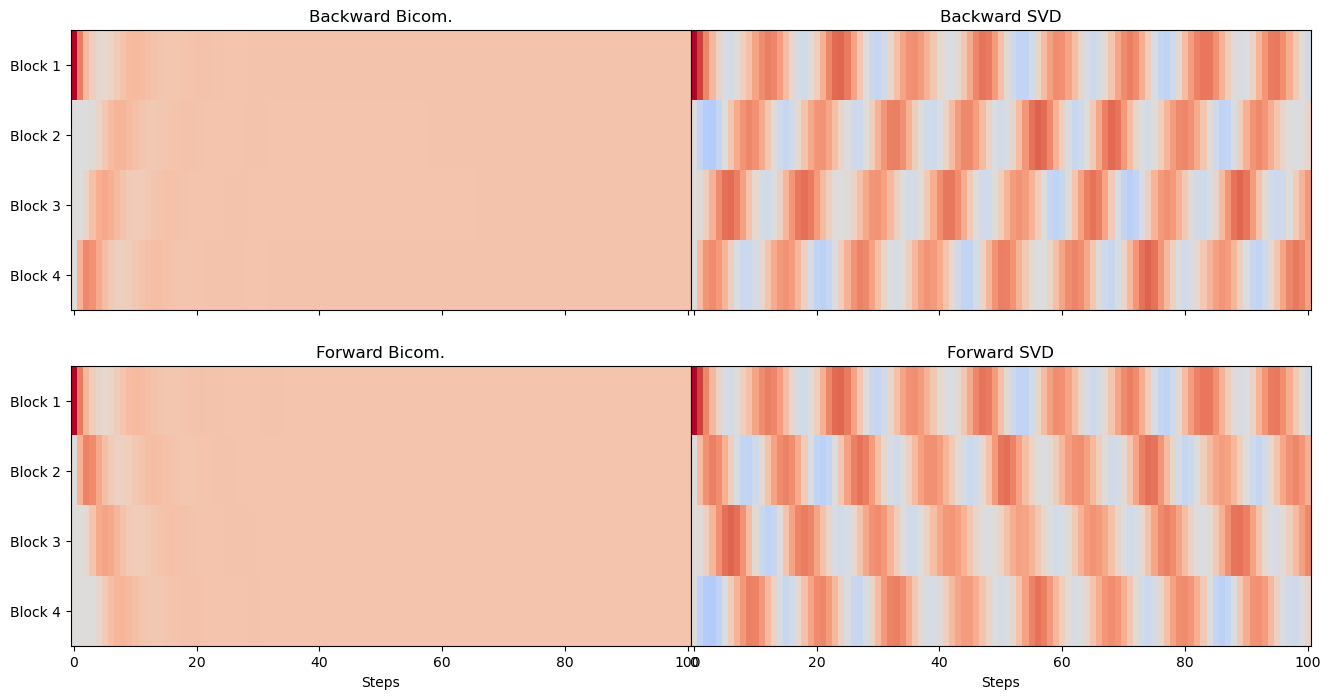

In [9]:
fig, all_axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), sharex=True, gridspec_kw={"hspace": 0.2, "wspace": 0})

for j, rec_type in enumerate([all_rec, all_rec_sing]):
    for i, rec in enumerate(rec_type):
        avg_sig = rec.reshape((-1, 4, n_per_com)).mean(axis=2).T
        all_axes[i, j].imshow(avg_sig, cmap="coolwarm", vmin=-1, vmax=1, interpolation="none", aspect="auto")

        all_axes[i, j].set_title(["Backward", "Forward"][i] + " " + ["Bicom.", "SVD"][j])

        all_axes[i, j].set_yticks([])
    all_axes[j, 0].set_yticks(range(4), labels=[f"Block {i+1}" for i in range(4)])
    all_axes[1, j].set_xlabel("Steps")

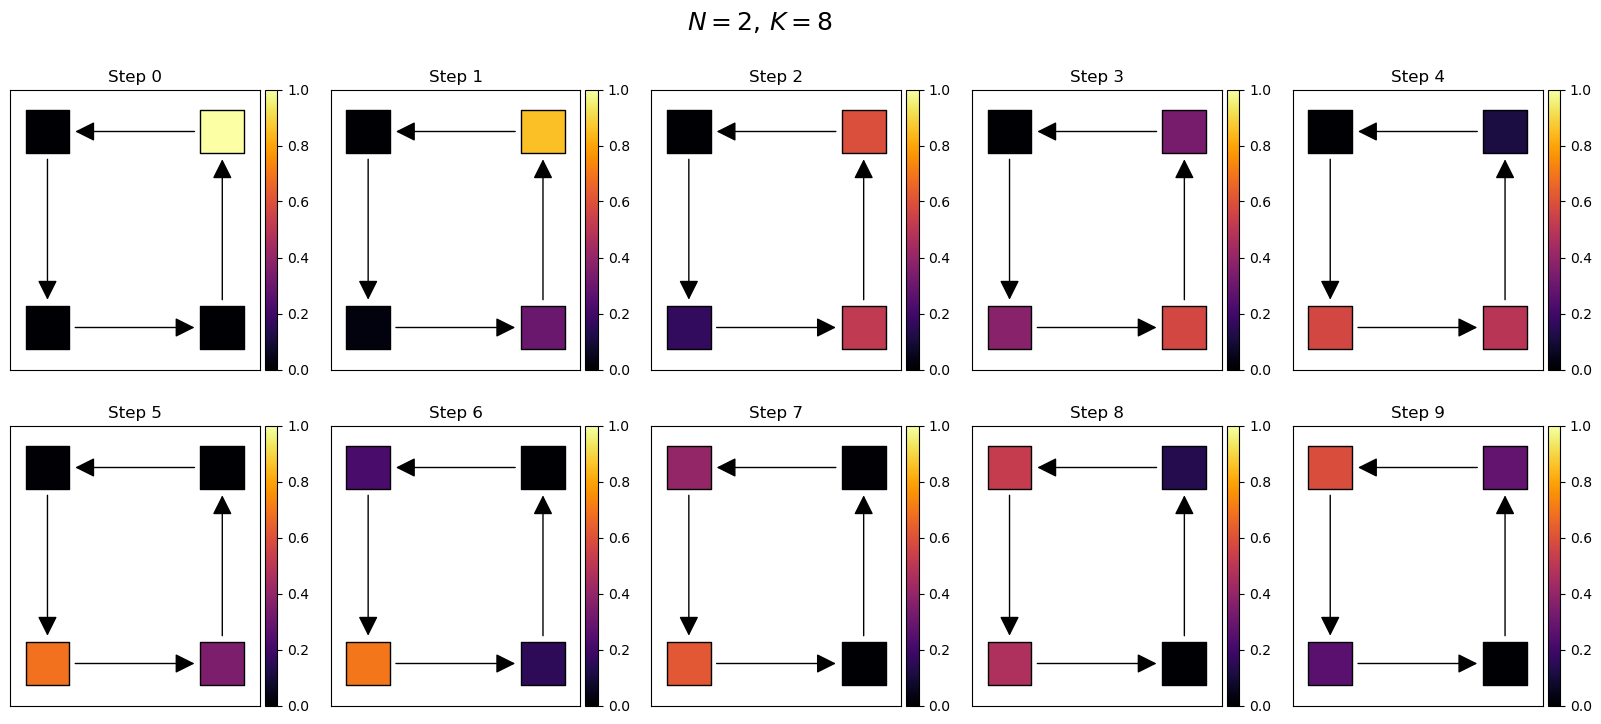

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

fig.suptitle(f"$N={n_vec_max},\,K={n_kmeans}$", fontsize=18)

k = 0
# for rec, ax in zip(all_rec[0], axes):
for rec, ax in zip(all_rec_sing[0], axes):
    plot_avg_cycle(rec, axes=ax, vmax=1)
    ax.set_title(f"Step {k}")
    k += 1

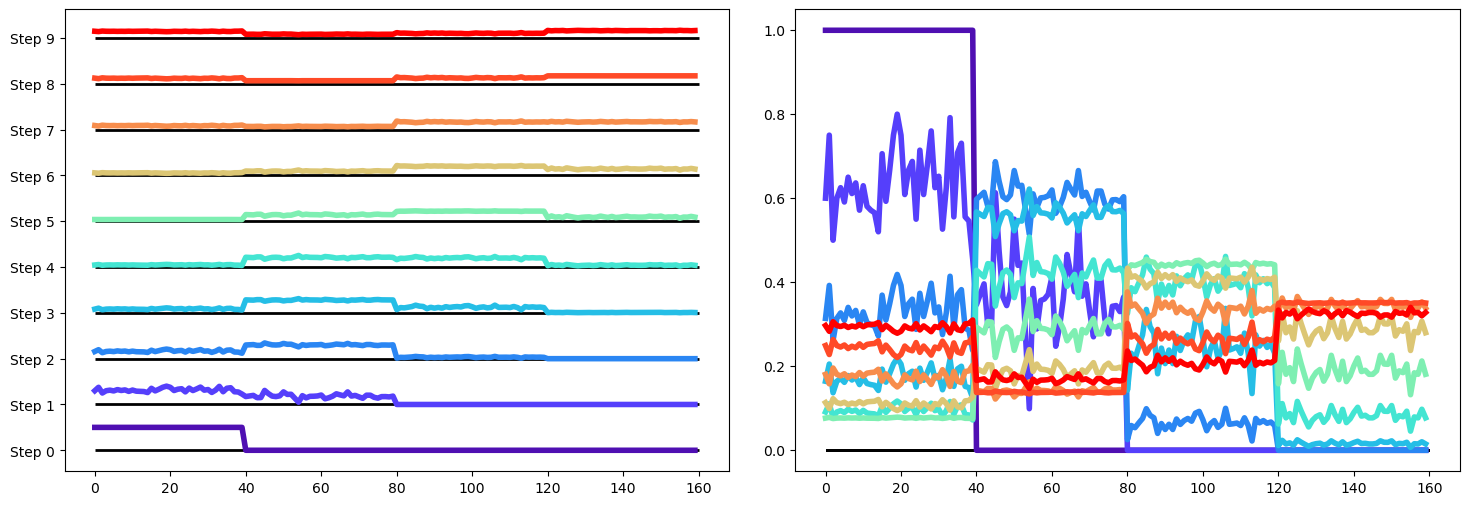

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 6), gridspec_kw={"wspace": 0.1})

n_rec_plot = 10

cmap_rec = cmap_8clusters.resampled(n_rec_plot+1)
for i, rec in enumerate(all_rec[1, :n_rec_plot]):
    axes[0].plot(2*i+rec, color=cmap_rec(i+1), lw=4)
    axes[0].hlines(2*i, 0, n_nodes, color="k", lw=2, zorder=0)
    
    axes[1].plot(rec, color=cmap_rec(i+1), lw=4)
    axes[1].hlines(0, 0, n_nodes, color="k", lw=2, zorder=0)

axes[0].set_yticks(2*np.arange(n_rec_plot), labels=[f"Step {t}" for t in np.arange(n_rec_plot)])

Found 8 clusters !
(200, 8)
(200, 200)
(200, 8)
(400, 8)


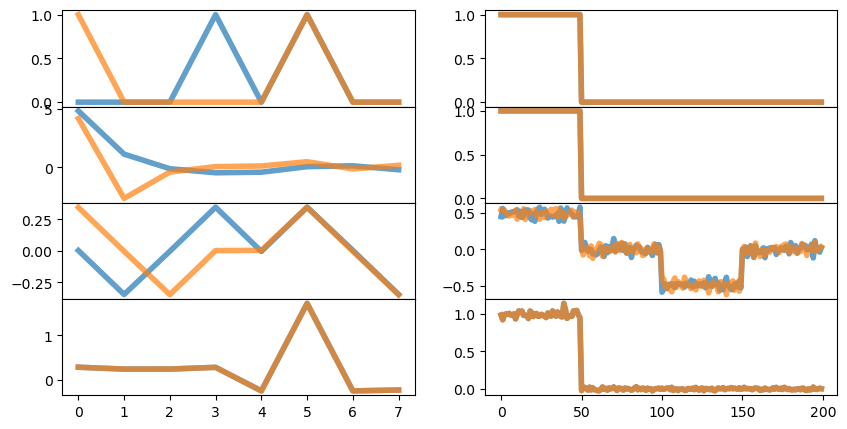

In [ ]:
importlib.reload(dgsp)

n_blocks = 4
n_per_com = 50

%matplotlib inline

# cmap = cmap_8clusters.resampled(len(all_n_blocks)+1)
adj = dgsp_graphs.block_cycle(n_per_com, n_blocks=n_blocks, com_density=1, connect_density=0.5, seed=28)

xt = np.zeros(len(adj))
xt[:n_per_com] += 1
# xt[:n_per_com//2] += 1
# xt[n_per_com:2*n_per_com] += 1
# xt[3*n_per_com:] += 1

B = dgsp.modularity_matrix(adj)
U, S, Vh = dgsp.sorted_SVD(B, fix_negative=False)
V = Vh.T

n_nodes = len(S)
    
n_vec_max = 2
scale_factor = S[:n_vec_max]
n_kmeans = 2*n_blocks
bicom = dgsp.edge_bicommunities(adj, U, V, n_vec_max, method="kmeans",
                                n_kmeans=n_kmeans, verbose=True,
                                max_k=10, scale_S=scale_factor,
                                return_centroids=True)

edge_clusters, edge_clusters_mat, centroids = bicom
n_clusters = np.max(edge_clusters)

c_out, c_in = dgsp.get_node_clusters(edge_clusters, edge_clusters_mat)

bimod_idx = dgsp.bimod_index_nodes(adj, c_out, c_in, scale=True)
sorting_array = np.flip(np.argsort(bimod_idx))

edge_clusters_mat_sorted = edge_clusters_mat.copy()
edge_clusters_sorted = edge_clusters.copy()
for i_new, i in enumerate(sorting_array):
    edge_clusters_mat_sorted[edge_clusters_mat == i+1] = i_new + 1
    edge_clusters_sorted[edge_clusters == i+1] = i_new + 1

edge_clusters_mat = edge_clusters_mat_sorted
edge_clusters = edge_clusters_sorted

c_out = c_out[sorting_array]
c_in = c_in[sorting_array]

c_mat = np.hstack([c_out, c_in]).T
c_mat_pinv = np.linalg.pinv(c_mat)

C_mat_out = c_out.T #/np.linalg.norm(c_out, axis=1)
c_pinv_out = np.linalg.pinv(C_mat_out)

C_mat_in = c_in.T #/np.linalg.norm(c_in, axis=1)
c_pinv_in = np.linalg.pinv(C_mat_in)

centroids = centroids[sorting_array]

cen_u = (centroids[:, 0] @ U[:, :centroids.shape[-1]].T).T
cen_v = (centroids[:, 1] @ V[:, :centroids.shape[-1]].T).T

cen_u_pinv = np.linalg.pinv(cen_u)
cen_v_pinv = np.linalg.pinv(cen_v)

coefs_in = c_pinv_in @ xt
coefs_out = c_pinv_out @ xt

coefs_V = V.T @ xt
coefs_U = U.T @ xt

coefs_cen_in = cen_v_pinv @ xt
coefs_cen_out = cen_u_pinv @ xt

coefs_cmat = c_mat_pinv @ np.hstack([xt, xt])

all_coefs = [[coefs_in, coefs_out], [coefs_V, coefs_U], [coefs_cen_in, coefs_cen_out], [coefs_cmat, coefs_cmat]]
all_recon = [[c_in.T, c_out.T], [V, U], [cen_v, cen_u], [c_mat, c_mat]]

fig, axes = plt.subplots(nrows=len(all_coefs), ncols=2, figsize=(10, 5), gridspec_kw={"hspace": 0})
for i, coefs in enumerate(all_coefs):
    axes[i, 0].plot(coefs[0][:n_kmeans], lw=4, alpha=0.7)
    axes[i, 0].plot(coefs[1][:n_kmeans], lw=4, alpha=0.7)
    
    print(all_recon[i][0].shape)
    rec_in = all_recon[i][0] @ coefs[0]
    rec_out = all_recon[i][1] @ coefs[1]

    if i == 3:
        rec_in = rec_in.reshape((2, -1)).mean(axis=0)
        rec_out = rec_out.reshape((2, -1)).mean(axis=0)

    axes[i, 1].plot(rec_in, lw=4, alpha=0.7)
    axes[i, 1].plot(rec_out, lw=4, alpha=0.7)

(8, 200)
(8, 200)


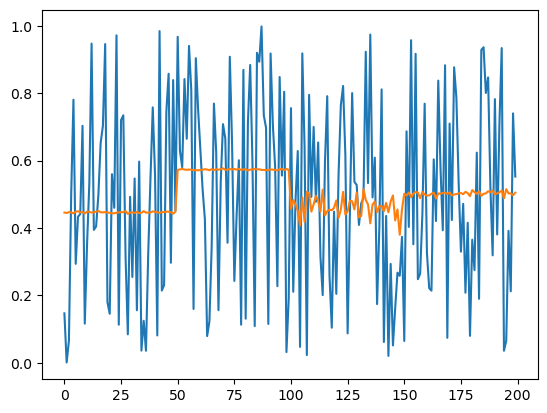

In [150]:
print(c_in.shape)
print(c_pinv_in.shape)

xt_second = np.random.uniform(0, 1, len(c_in[0]))

plt.plot(xt_second)
plt.plot((c_in.T @ c_pinv_in) @ xt_second)
# fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
# axes[0].imshow(c_in.T @ c_pinv_in)
# axes[1].imshow(c_pinv_in @ c_in.T)

### Benchmark Norms

In [12]:
n_trials = 100

k_max = 10
all_ks = np.arange(2, k_max+1, 1)

all_rec = np.zeros((len(all_ks), n_trials+1, n_nodes))
all_rec_for = np.zeros((len(all_ks), n_trials+1, n_nodes))
all_corr = np.zeros((len(all_ks), n_trials+1))

xt = np.zeros(len(graph))
xt[:n_per_com] += 1
# xt[:n_per_com//2] += 1
# xt[n_per_com:2*n_per_com] += 1
# xt[3*n_per_com:] += 1

n_vec_max = 2
for k, n_kmeans in enumerate(all_ks):
    edge_clusters, edge_clusters_mat = dgsp.edge_bicommunities(graph, U, V, n_vec_max, method="kmeans",
                                                            n_kmeans=n_kmeans, verbose=True, max_k=10, scale_S=scale_factor)
    n_clusters = np.max(edge_clusters)
    # cmap_to_use = cmap_8clusters.resampled(n_clusters+1)

    c_out, c_in = dgsp.get_node_clusters(edge_clusters, edge_clusters_mat)

    bimod_idx = dgsp.bimod_index_nodes(graph, c_out, c_in, scale=True)
    sorting_array = np.flip(np.argsort(bimod_idx))

    edge_clusters_mat_sorted = edge_clusters_mat.copy()
    edge_clusters_sorted = edge_clusters.copy()
    for i_new, i in enumerate(sorting_array):
        edge_clusters_mat_sorted[edge_clusters_mat == i+1] = i_new + 1
        edge_clusters_sorted[edge_clusters == i+1] = i_new + 1

    edge_clusters_mat = edge_clusters_mat_sorted
    edge_clusters = edge_clusters_sorted

    c_out = c_out[sorting_array]
    c_in = c_in[sorting_array]

    C_mat_out = c_out.T/np.linalg.norm(c_out, axis=1)
    c_pinv_out = np.linalg.pinv(C_mat_out)

    C_mat_in = c_in.T/np.linalg.norm(c_in, axis=1)
    c_pinv_in = np.linalg.pinv(C_mat_in)

    all_rec[k, 0] = xt
    all_rec_for[k, 0] = xt
    all_corr[k, 0] = 1

    xt = np.zeros(len(graph))
    xt[:n_per_com] += 1
    # xt[:n_per_com//2] += 1
    xt[n_per_com:2*n_per_com] += 1
    # xt[3*n_per_com:] += 1

    x_hat_source = xt.copy()
    x_hat_target = xt.copy()
    for i in range(n_trials):
        coefs_in = c_pinv_in @ x_hat_source
        coefs_out = c_pinv_out @ x_hat_target

        x_hat_source = C_mat_out @ coefs_in
        x_hat_target = C_mat_in @ coefs_out
        
        # x_hat_source = U @ V.T @ x_hat_source

        all_rec[k, i+1] = x_hat_source
        all_rec_for[k, i+1] = x_hat_target
        all_corr[k, i+1] = pearsonr(x_hat_source, xt)[0]

Found 2 clusters !
Found 3 clusters !
Found 4 clusters !
Found 5 clusters !
Found 6 clusters !
Found 7 clusters !
Found 8 clusters !
Found 9 clusters !
Found 10 clusters !


(-1.0, 100.0)

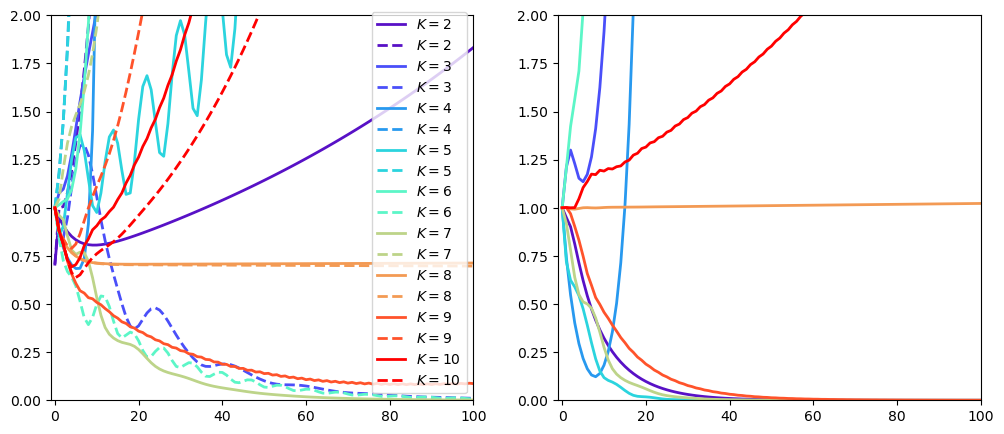

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

for i, norm in enumerate(np.linalg.norm(all_rec, axis=2)):
    axes[0].plot(norm/np.linalg.norm(xt), color=cmap_8clusters.resampled(len(all_ks)+1)(i+1), lw=2, label=f"$K={all_ks[i]}$")
    norm2 = np.linalg.norm(all_rec_for[i], axis=1)
    axes[0].plot(norm2/np.linalg.norm(xt), color=cmap_8clusters.resampled(len(all_ks)+1)(i+1), ls="--", lw=2, label=f"$K={all_ks[i]}$")
    
    axes[1].plot(norm/norm2, color=cmap_8clusters.resampled(len(all_ks)+1)(i+1), lw=2, label=f"$K={all_ks[i]}$")
# axes.plot((np.linalg.norm(all_rec, axis=2)/np.linalg.norm(xt)).T)
# axes.set_xticklabels(all_ks)

axes[0].set_ylim(0, 2)
axes[0].set_xlim(-1, 100)
axes[0].legend()

axes[1].set_ylim(0, 2)
axes[1].set_xlim(-1, 100)

(9, 101)


/var/folders/nj/ltrlv15x5jj2jq78pbb2srz80000gn/T/ipykernel_2315/3097496096.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels(all_ks)


[Text(0, -1.0, '2'),
 Text(0, 0.0, '3'),
 Text(0, 1.0, '4'),
 Text(0, 2.0, '5'),
 Text(0, 3.0, '6'),
 Text(0, 4.0, '7'),
 Text(0, 5.0, '8'),
 Text(0, 6.0, '9'),
 Text(0, 7.0, '10'),
 Text(0, 8.0, ''),
 Text(0, 9.0, '')]

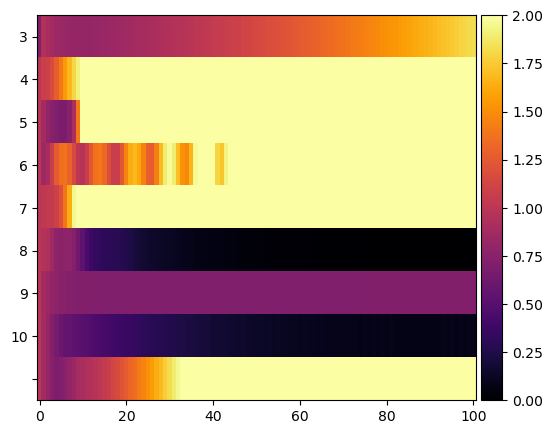

In [14]:
fig, axes = plt.subplots(figsize=(6, 5))

print(np.linalg.norm(all_rec, axis=2).shape)

axes.imshow(np.linalg.norm(all_rec, axis=2)/np.linalg.norm(xt), aspect="auto",
           cmap="inferno", vmin=0, vmax=2, interpolation="none")
plot.add_cbar(fig, axes)

axes.set_yticklabels(all_ks)

## Block Cycle Size

Found 8 clusters !


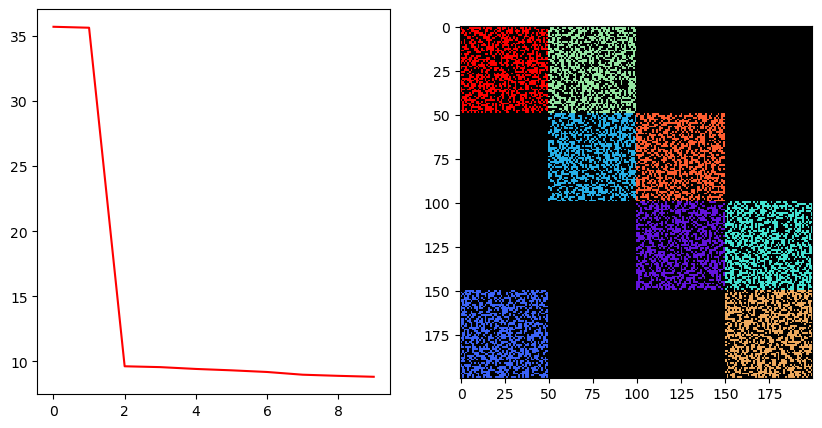

In [79]:
importlib.reload(dgsp)

all_n_blocks = np.arange(2, 10, 1)
all_n_blocks = [3, 4, 5, 6, 8]
all_nvecs = [2, 2, 4, 4, 7]
all_nvecs = [3, 4, 4, 4, 7]
all_n_blocks = [3, 4]
all_n_blocks = [4]

n_trials = 100
n_per_com = 50

all_rec = np.zeros((2, len(all_n_blocks), n_trials+1, n_per_com))
all_rec_sing = np.zeros((2, len(all_n_blocks), n_trials+1, n_per_com))
all_rec_sing_like = np.zeros((2, len(all_n_blocks), n_trials+1, n_per_com))

%matplotlib inline
fig, axes = plt.subplots(ncols=len(all_n_blocks) + 1, figsize=(5 + len(all_n_blocks)*5, 5))

cmap = cmap_8clusters.resampled(len(all_n_blocks)+1)
for n, n_blocks in enumerate(all_n_blocks):
    adj = dgsp_graphs.block_cycle(n_per_com, n_blocks=n_blocks, com_density=1, connect_density=0.5, seed=28)

    xt = np.zeros(len(adj))
    xt[:n_per_com] += 1
    # xt[:n_per_com//2] += 1
    # xt[n_per_com:2*n_per_com] += 1
    # xt[3*n_per_com:] += 1

    B = dgsp.modularity_matrix(adj)
    U, S, Vh = dgsp.sorted_SVD(B, fix_negative=False)
    V = Vh.T

    n_nodes = len(S)

    axes[0].plot(S[:10], label=f"$N={n_blocks}$", color=cmap(n+1))
    
    # perc_thresh = np.percentile(S, 97)
    # axes[0].plot([0, 10], [perc_thresh]*2, color=cmap(n+1))

    # Inflection point
    # diff2 = np.diff(np.diff(S))
    # infl = np.min(np.where(np.abs(diff2) < 1)[0])
    # axes[0].scatter(infl, S[infl], color="none", edgecolor=cmap(n+1), lw=2, s=100)
    
    n_vec_max = all_nvecs[n]
    scale_factor = S[:n_vec_max]
    n_kmeans = 2*n_blocks
    bicom = dgsp.edge_bicommunities(adj, U, V, n_vec_max, method="kmeans",
                                    n_kmeans=n_kmeans, verbose=True,
                                    max_k=10, scale_S=scale_factor,
                                    return_centroids=True)
    
    edge_clusters, edge_clusters_mat, centroids = bicom
    n_clusters = np.max(edge_clusters)

    axes[n+1].imshow(edge_clusters_mat, cmap=cmap_8clusters.resampled(n_clusters+1),
                     vmin=0, vmax=n_clusters, interpolation="none")

    c_out, c_in = dgsp.get_node_clusters(edge_clusters, edge_clusters_mat)

    bimod_idx = dgsp.bimod_index_nodes(adj, c_out, c_in, scale=True)
    sorting_array = np.flip(np.argsort(bimod_idx))

    edge_clusters_mat_sorted = edge_clusters_mat.copy()
    edge_clusters_sorted = edge_clusters.copy()
    for i_new, i in enumerate(sorting_array):
        edge_clusters_mat_sorted[edge_clusters_mat == i+1] = i_new + 1
        edge_clusters_sorted[edge_clusters == i+1] = i_new + 1

    edge_clusters_mat = edge_clusters_mat_sorted
    edge_clusters = edge_clusters_sorted

    c_out = c_out[sorting_array]
    c_in = c_in[sorting_array]

    C_mat_out = c_out.T #/np.linalg.norm(c_out, axis=1)
    c_pinv_out = np.linalg.pinv(C_mat_out)

    C_mat_in = c_in.T #/np.linalg.norm(c_in, axis=1)
    c_pinv_in = np.linalg.pinv(C_mat_in)

    centroids = centroids[sorting_array]

    cen_u = (centroids[:, 0] @ U[:, :centroids.shape[-1]].T).T
    cen_v = (centroids[:, 1] @ V[:, :centroids.shape[-1]].T).T
    
    cen_u_pinv = np.linalg.pinv(cen_u)
    cen_v_pinv = np.linalg.pinv(cen_v)

    all_rec[0, n, 0] = xt[:n_per_com]
    all_rec[1, n, 0] = xt[:n_per_com]
    
    all_rec_sing[0, n, 0] = xt[:n_per_com]
    all_rec_sing[1, n, 0] = xt[:n_per_com]

    all_rec_sing_like[0, n, 0] = xt[:n_per_com]
    all_rec_sing_like[1, n, 0] = xt[:n_per_com]

    last_rec1 = [xt.copy()]*2
    last_rec2 = [xt.copy()]*2
    last_rec3 = [xt.copy()]*2
    for i in range(n_trials):
        coefs_in = c_pinv_in @ last_rec1[0]
        coefs_out = c_pinv_out @ last_rec1[1]
        
        last_rec1[0] = C_mat_out @ coefs_in
        last_rec1[1] = C_mat_in @ coefs_out

        all_rec[0, n, i+1] = last_rec1[0][:n_per_com]
        all_rec[1, n, i+1] = last_rec1[1][:n_per_com]

        last_rec2[0] = U @ (V.T @ last_rec2[0])
        last_rec2[1] = V @ (U.T @ last_rec2[1])

        all_rec_sing[0, n, i+1] = last_rec2[0][:n_per_com]
        all_rec_sing[1, n, i+1] = last_rec2[1][:n_per_com]

        last_rec3[0] = cen_u @ (cen_v_pinv @ last_rec3[0])
        last_rec3[1] = cen_v @ (cen_u_pinv @ last_rec3[1])
    
        all_rec_sing_like[0, n, i+1] = last_rec3[0][:n_per_com]
        all_rec_sing_like[1, n, i+1] = last_rec3[1][:n_per_com]

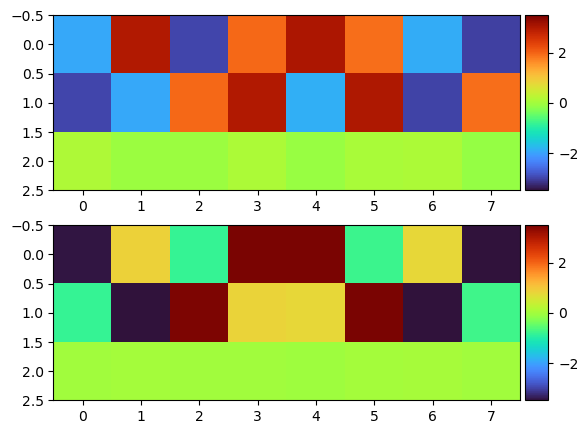

In [80]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))

maxval = np.abs(centroids).max()
for i, ax in enumerate(axes):
    ax.imshow(centroids[:, i].T, cmap="turbo", vmin=-maxval, vmax=maxval)
    plot.add_cbar(fig, ax)

$\bar{\mathbf{U}}\in\mathbb{R}^{K\times N_{Comp}}$ and $\bar{\mathbf{V}}\in\mathbb{R}^{K\times N_{Comp}}$

$\bar{\mathbf{U}}_k\in\mathbb{R}^{N_{Comp}}$ and $\bar{\mathbf{V}}_k\in\mathbb{R}^{N_{Comp}}$

$\mathbf{U}\in\mathbb{R}^{NxN_{Comp}}$ and $\mathbf{V}\in\mathbb{R}^{NxN_{Comp}}$



(150, 6)


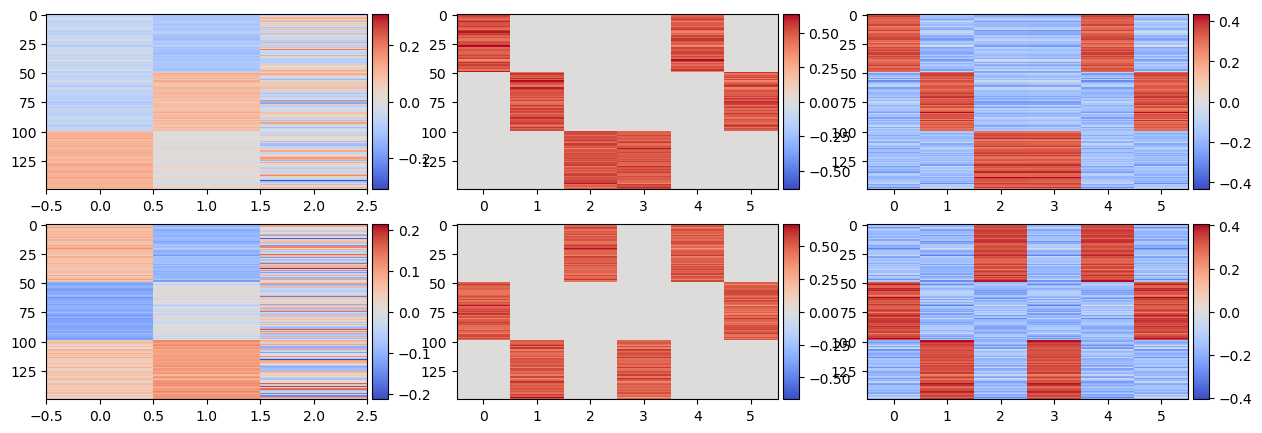

In [76]:
cen_u = U[:, :centroids.shape[-1]] @ centroids[:, 0].T
cen_v = V[:, :centroids.shape[-1]] @ centroids[:, 1].T

print(cen_v.shape)

all_ctypes = [[U[:, :centroids.shape[-1]], V[:, :centroids.shape[-1]]], [c_out.T, c_in.T], [cen_u, cen_v]]

fig, axes = plt.subplots(nrows=2, ncols=len(all_ctypes), figsize=(15, 5))

for j, c_types in enumerate(all_ctypes):
    for i, cen in enumerate(c_types):
        maxval = np.max(np.abs(cen))
        axes[i, j].imshow(cen, cmap="coolwarm", interpolation="none", aspect="auto", vmin=-maxval, vmax=maxval)

        plot.add_cbar(fig, axes[i, j])

# fig, axes = plt.subplots(nrows=2, ncols=n_clusters//2, figsize=(5*n_clusters//2, 10))
# axes = axes.flatten()

# for i, ax in enumerate(axes):
#     ax.scatter(cen_u[i], cen_v[i], c=np.arange(n_nodes), cmap="turbo")

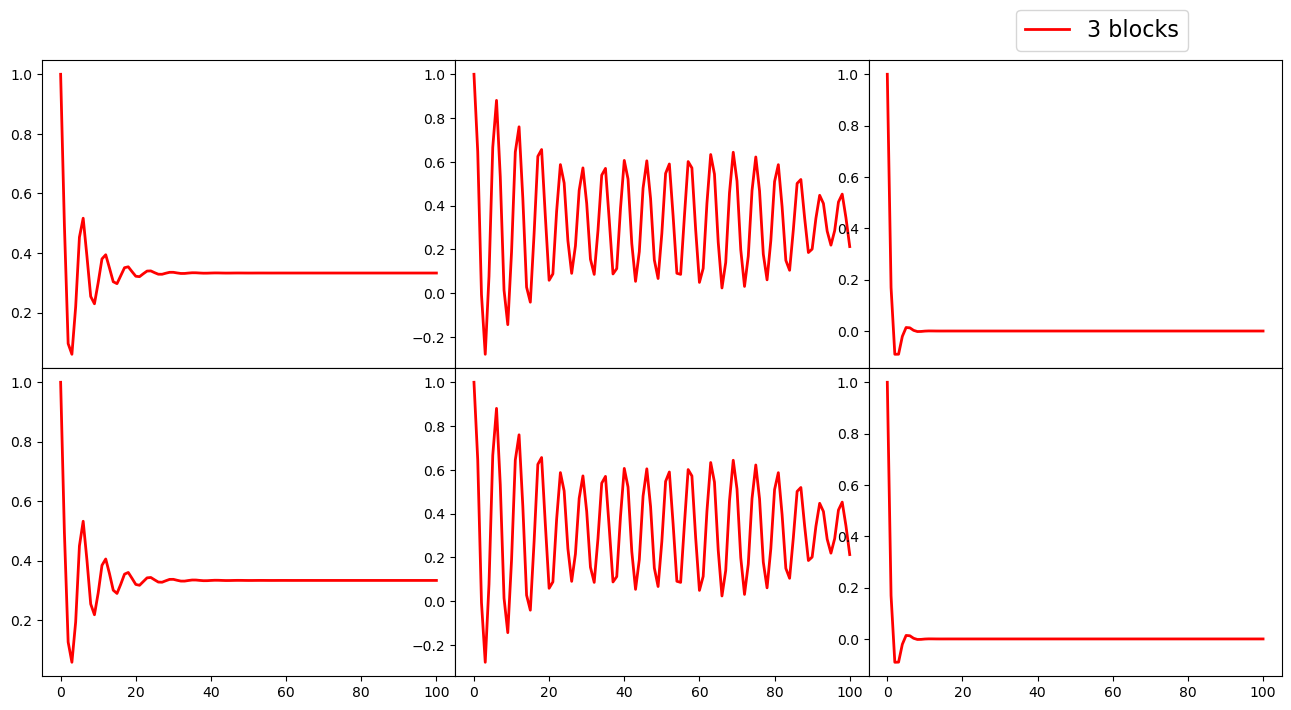

In [66]:
fig, all_axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), #sharey=True,
                             gridspec_kw={"hspace": 0, "wspace": 0})

cmap = cmap_8clusters.resampled(len(all_n_blocks)+1)
for axes, rec_type in zip(all_axes.T, [all_rec, all_rec_sing, all_rec_sing_like]):
    for ax_i, rec in enumerate(rec_type):
        for i, avg_sig in enumerate(rec):
            axes[ax_i].plot(avg_sig[:, :n_per_com].mean(axis=1), lw=2, color=cmap(i+1), label=f"{all_n_blocks[i]} blocks")

        # axes[ax_i].plot(np.linalg.norm(rec, axis=1)/np.linalg.norm(xt), ls="--", lw=4, alpha=0.5, color="k", label="Prop. norm")

axes[0].legend(ncols=len(all_n_blocks)//2, bbox_to_anchor=[0.8, 1.2], fontsize=16)

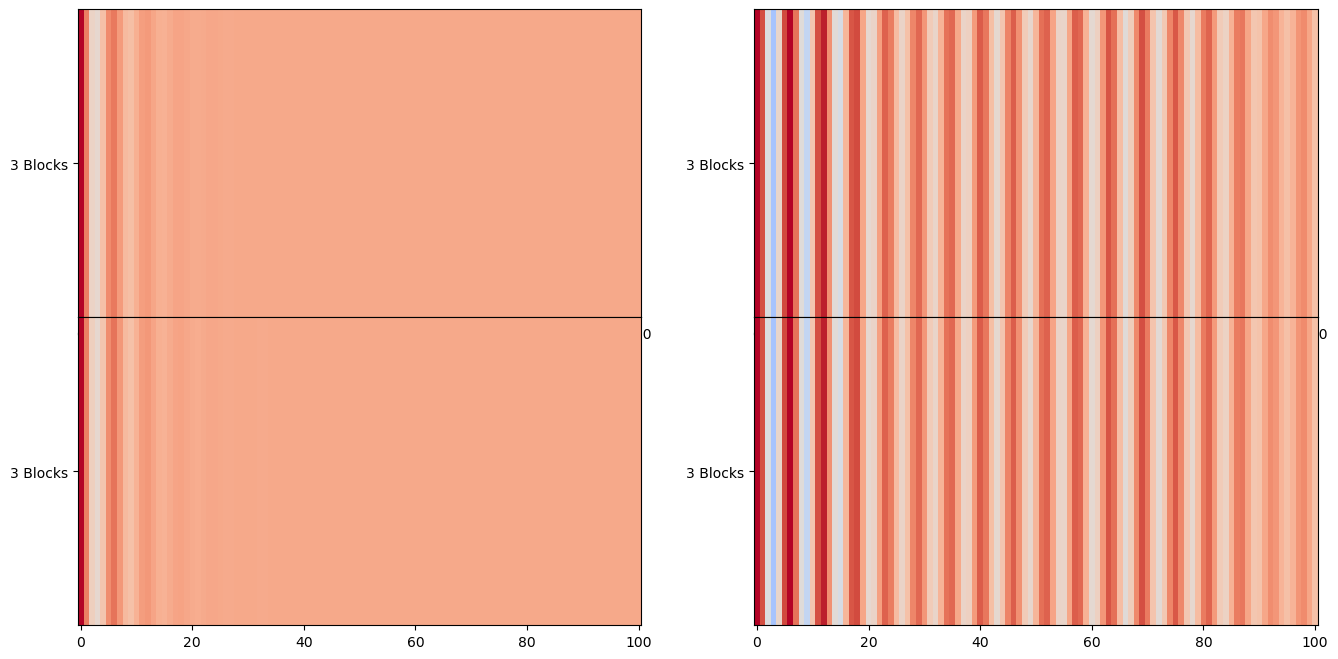

In [26]:
fig, all_axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), #sharey=True,
                             gridspec_kw={"hspace": 0, "wspace": 0.2})

cmap = cmap_8clusters.resampled(len(all_n_blocks)+1)
for axes, rec_type in zip(all_axes.T, [all_rec, all_rec_sing]):
    for ax_i, rec in enumerate(rec_type):
        axes[ax_i].imshow(rec[:, :, :n_per_com].mean(axis=-1), cmap="coolwarm", vmin=-0.8, vmax=0.8, aspect="auto")

        axes[ax_i].set_yticks(range(len(all_n_blocks)), labels=[f"{n} Blocks" for n in all_n_blocks])

interactive(children=(IntSlider(value=0, description='step'), Dropdown(description='n_blocks', options=(3, 10,…

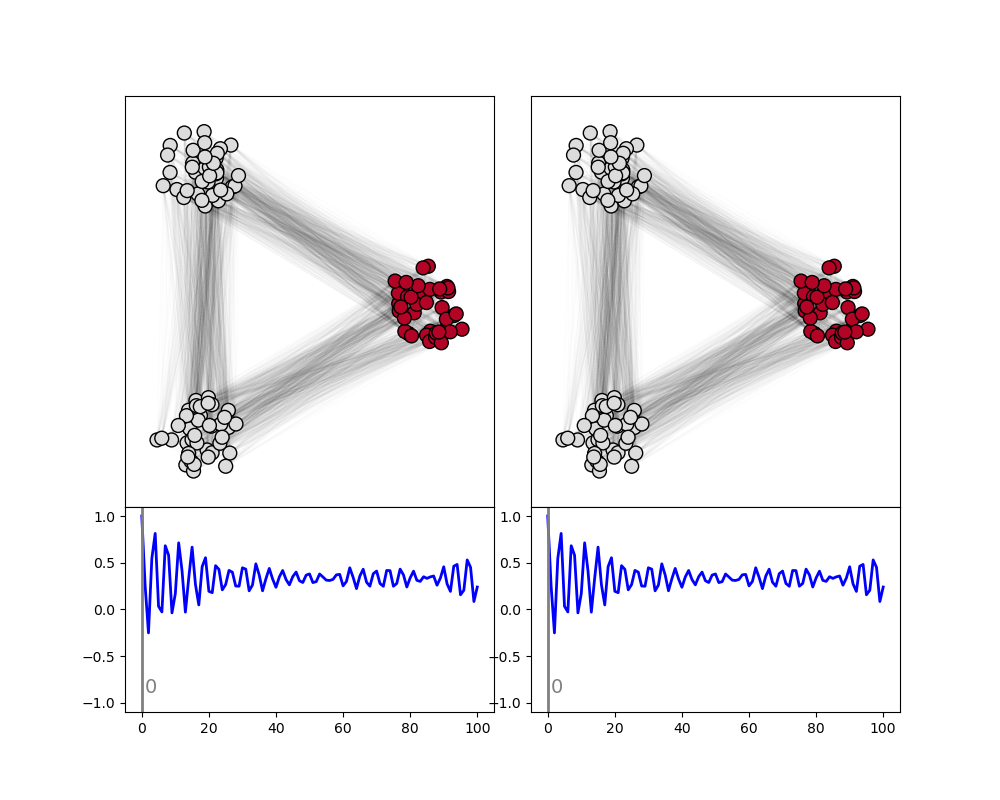

In [27]:
from matplotlib import animation
from ipywidgets import interact, widgets

%matplotlib widget

importlib.reload(dgsp)
importlib.reload(plot)

fig, all_axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), #sharey=True,
                            gridspec_kw={"hspace": 0, "wspace": 0.1, "height_ratios": [2, 1]})

step = 10
n_per_com = 50
n_per_com = 40

def animate_step(step, n_blocks, use_uvt, com_density, connect_density, shortcut, seed, filtered):

    circular_pos, graph_pos = plot.circular_layout(n_blocks, n_per_com, radius=2, small_radius=0.3, return_dict=True)

    adj = dgsp_graphs.block_cycle(n_per_com, n_blocks=n_blocks, com_density=com_density, connect_density=connect_density, seed=seed)
    n_nodes = len(adj)

    kmeans_offset = 0
    if (n_blocks == 8) and (shortcut):
        adj[2*n_per_com:3*n_per_com][:, 7*n_per_com:8*n_per_com] = dgsp_graphs.random_connector(n_per_com, connect_density, out_prob=1, seed=seed+10)[0]
        # adj[2*n_per_com:3*n_per_com][:, 7*n_per_com:8*n_per_com] = dgsp_graphs.random_connector(n_per_com, connect_density, out_prob=0.5, seed=28+10)[0]
        # adj[7*n_per_com:8*n_per_com][:, 2*n_per_com:3*n_per_com] = dgsp_graphs.random_connector(n_per_com, connect_density, out_prob=0.5, seed=28+11)[0]
        kmeans_offset = 1
        # kmeans_offset = 2

    xt = np.zeros(n_nodes)
    xt[:n_per_com] += 1
    # xt[:n_per_com//2] += 1
    # xt[n_per_com:2*n_per_com] += 1
    # xt[3*n_per_com:] += 1

    U, S, Vh = dgsp.sorted_SVD(dgsp.modularity_matrix(adj), fix_negative=False)
    V = Vh.T

    n_kmeans = n_blocks * 2 + kmeans_offset
    if (com_density == 0) or (connect_density == 0):
        n_kmeans = n_blocks + kmeans_offset

    C_mat_out, c_pinv_out, C_mat_in, c_pinv_in, bimod_idx = dgsp.get_c_pinv(adj, all_nvecs[n], n_kmeans, normalize=False)
    print(bimod_idx)

    if "High" in filtered:
        c_pinv_out[n_kmeans//2:] = 0
        c_pinv_in[n_kmeans//2:] = 0
    if "Low" in filtered:
        c_pinv_out[:n_kmeans//2] = 0
        c_pinv_in[:n_kmeans//2] = 0

    all_rec = np.zeros((2, n_trials+1, n_nodes))
    all_rec_sing = np.zeros((2, n_trials+1, n_nodes))

    all_rec[0, 0] = xt
    all_rec[1, 0] = xt

    all_rec_sing[0, 0] = xt
    all_rec_sing[1, 0] = xt

    for i in range(n_trials):
        coefs_in = c_pinv_in @ all_rec[0, i]
        coefs_out = c_pinv_out @ all_rec[1, i]
        
        all_rec[0, i+1] = C_mat_out @ coefs_in
        all_rec[1, i+1] = C_mat_in @ coefs_out

        all_rec_sing[0, i+1] = U @ (V.T @ all_rec_sing[0, i])
        all_rec_sing[1, i+1] = V @ (U.T @ all_rec_sing[1, i])

    if use_uvt:
        rec_to_use = all_rec_sing
    else:
        rec_to_use = all_rec

    for ax_i, rec in enumerate(rec_to_use):
        all_axes[0, ax_i].clear()
        all_axes[0, ax_i].scatter(circular_pos[0], circular_pos[1], c=rec[step], cmap="coolwarm", vmin=-1, vmax=1,
                                s=100, edgecolor="k", linewidth=1, zorder=2)
        nx.draw_networkx_edges(nx.Graph(adj), pos=graph_pos, ax=all_axes[0, ax_i], edge_color="k",
                            alpha=0.01, arrows=False)

        all_axes[1, ax_i].clear()
        plot_sig = rec[:, :n_per_com].mean(axis=-1)
        all_axes[1, ax_i].plot(plot_sig, lw=2, color="b")
        # all_axes[1, ax_i].vlines(step, plot_sig.min(), plot_sig.max(), color="gray", lw=2)
        # all_axes[1, ax_i].text(step+1, 0.9*plot_sig.min(), f"{step}", fontsize=14, color="gray")
        all_axes[1, ax_i].vlines(step, -1.2, 1.2, color="gray", lw=2)
        all_axes[1, ax_i].text(step+1, -0.9, f"{step}", fontsize=14, color="gray")

        all_axes[1, ax_i].set_ylim(-1.1, 1.1)

    fignum_list = plt.get_fignums()

    if len(fignum_list) > 1:
        plt.close(fignum_list[0])
    return

_ = interact(animate_step, step=widgets.IntSlider(value=0, min=0, max=n_trials, step=1), n_blocks=all_n_blocks+[10, 12],
             use_uvt=True, shortcut=False, seed=28, filtered=["All", "High Only", "Low Only"],
             com_density=widgets.FloatSlider(value=0.4, min=0, max=1), connect_density=widgets.FloatSlider(value=0.5, min=0, max=1))

interactive(children=(IntSlider(value=0, description='step'), Dropdown(description='n_blocks', options=(3, 10,…

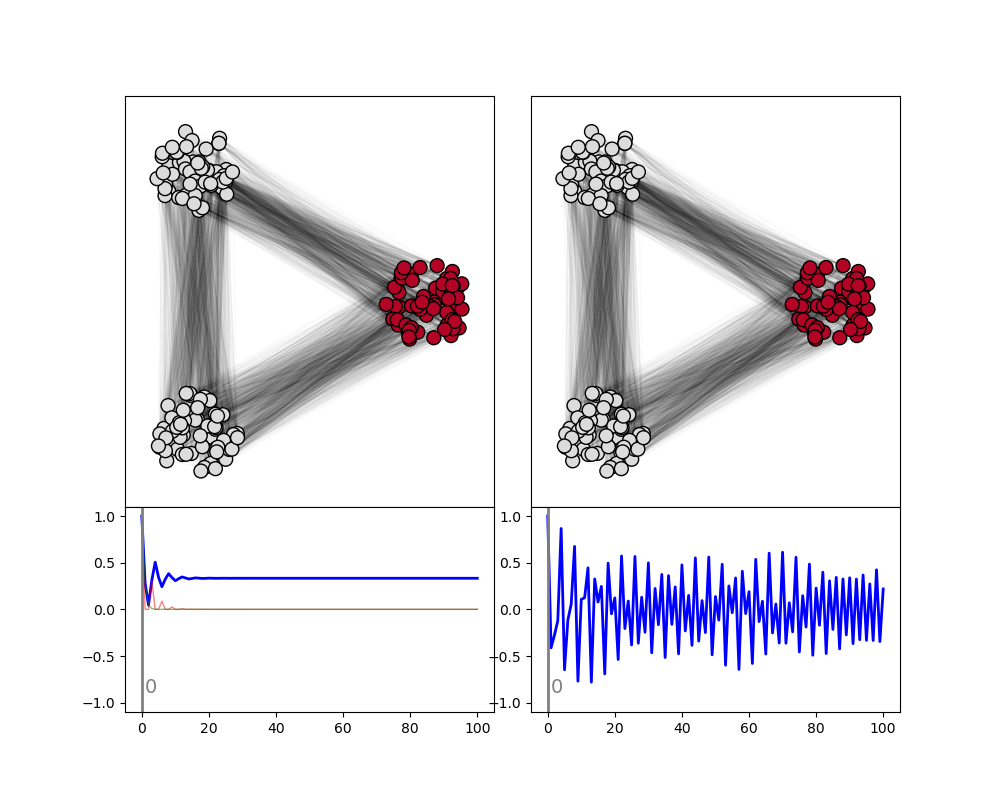

In [31]:
from matplotlib import animation
from ipywidgets import interact, widgets

%matplotlib widget

importlib.reload(dgsp)
importlib.reload(plot)

fig, all_axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), #sharey=True,
                            gridspec_kw={"hspace": 0, "wspace": 0.1, "height_ratios": [2, 1]})

step = 10
n_per_com = 50
n_per_com = 60

n_trials = 100

def animate_step(step, n_blocks, com_density, connect_density, shortcut, seed, normalize, ones):

    circular_pos, graph_pos = plot.circular_layout(n_blocks, n_per_com, radius=2, small_radius=0.3, return_dict=True)

    adj = dgsp_graphs.block_cycle(n_per_com, n_blocks=n_blocks, com_density=com_density, connect_density=connect_density, seed=seed)
    n_nodes = len(adj)

    kmeans_offset = 0
    if (n_blocks == 8) and (shortcut):
        adj[2*n_per_com:3*n_per_com][:, 7*n_per_com:8*n_per_com] = dgsp_graphs.random_connector(n_per_com, connect_density, out_prob=1, seed=seed+10)[0]
        # adj[2*n_per_com:3*n_per_com][:, 7*n_per_com:8*n_per_com] = dgsp_graphs.random_connector(n_per_com, connect_density, out_prob=0.5, seed=28+10)[0]
        # adj[7*n_per_com:8*n_per_com][:, 2*n_per_com:3*n_per_com] = dgsp_graphs.random_connector(n_per_com, connect_density, out_prob=0.5, seed=28+11)[0]
        kmeans_offset = 1
        # kmeans_offset = 2

    xt = np.zeros(n_nodes)
    xt[:n_per_com] += 1
    # xt[:n_per_com//2] += 1
    # xt[n_per_com:2*n_per_com] += 1
    # xt[3*n_per_com:] += 1

    U, S, Vh = dgsp.sorted_SVD(dgsp.modularity_matrix(adj), fix_negative=False)
    V = Vh.T

    n_kmeans = n_blocks * 2 + kmeans_offset
    if (com_density == 0) or (connect_density == 0):
        n_kmeans = n_blocks + kmeans_offset

    C_mat_out, c_pinv_out, C_mat_in, c_pinv_in, bimod_idx = dgsp.get_c_pinv(adj, all_nvecs[n], n_kmeans, normalize=normalize, ones=ones)
    print(bimod_idx)

    c_pinv_in_high = c_pinv_in.copy()
    c_pinv_in_high[n_kmeans//2:] = 0

    c_pinv_in_low = c_pinv_in.copy()
    c_pinv_in_low[:n_kmeans//2] = 0

    all_rec = np.zeros((n_trials+1, n_nodes))
    all_rec_high = np.zeros((n_trials+1, n_nodes))
    all_rec_low = np.zeros((n_trials+1, n_nodes))
    all_rec_sing = np.zeros((n_trials+1, n_nodes))

    all_rec[0] = xt
    all_rec_high[0] = xt
    all_rec_low[0] = xt

    all_rec_sing[0] = xt

    for i in range(n_trials):
        coefs_in = c_pinv_in @ all_rec[i]
        c_high = c_pinv_in_high @ all_rec_high[i]
        c_low = c_pinv_in_low @ all_rec_low[i]
        
        all_rec[i+1] = C_mat_out @ coefs_in
    
        all_rec_high[i+1] = C_mat_out @ c_high
        all_rec_low[i+1] = C_mat_out @ c_low
        all_rec_sing[i+1] = U @ (V.T @ all_rec_sing[i])

    for ax_i, rec in enumerate([all_rec, all_rec_sing]):
        all_axes[0, ax_i].clear()
        all_axes[0, ax_i].scatter(circular_pos[0], circular_pos[1], c=rec[step], cmap="coolwarm", vmin=-1, vmax=1,
                                s=100, edgecolor="k", linewidth=1, zorder=2)
        nx.draw_networkx_edges(nx.Graph(adj), pos=graph_pos, ax=all_axes[0, ax_i], edge_color="k",
                            alpha=0.01, arrows=False)

        all_axes[1, ax_i].clear()
        plot_sig = rec[:, :n_per_com].mean(axis=-1)
        all_axes[1, ax_i].plot(plot_sig, lw=2, color="b", zorder=1)
        
        if ax_i == 0:
            all_axes[1, ax_i].plot(all_rec_high[:, :n_per_com].mean(axis=-1), lw=1, color="r", alpha=0.5, zorder=2)
            all_axes[1, ax_i].plot(all_rec_low[:, :n_per_com].mean(axis=-1), lw=1, color="g", alpha=0.5, zorder=2)
        # all_axes[1, ax_i].vlines(step, plot_sig.min(), plot_sig.max(), color="gray", lw=2)
        # all_axes[1, ax_i].text(step+1, 0.9*plot_sig.min(), f"{step}", fontsize=14, color="gray")
        all_axes[1, ax_i].vlines(step, -1.2, 1.2, color="gray", lw=2)
        all_axes[1, ax_i].text(step+1, -0.9, f"{step}", fontsize=14, color="gray")

        all_axes[1, ax_i].set_ylim(-1.1, 1.1)

    fignum_list = plt.get_fignums()

    if len(fignum_list) > 1:
        plt.close(fignum_list[0])
    return

_ = interact(animate_step, step=widgets.IntSlider(value=0, min=0, max=n_trials, step=1), n_blocks=all_n_blocks+[10, 12],
             use_uvt=True, shortcut=False, seed=28, normalize=False, ones=False,
             com_density=widgets.FloatSlider(value=0.4, min=0, max=1),
             connect_density=widgets.FloatSlider(value=0.5, min=0, max=1))

Text(0.5, 0, 'Step')

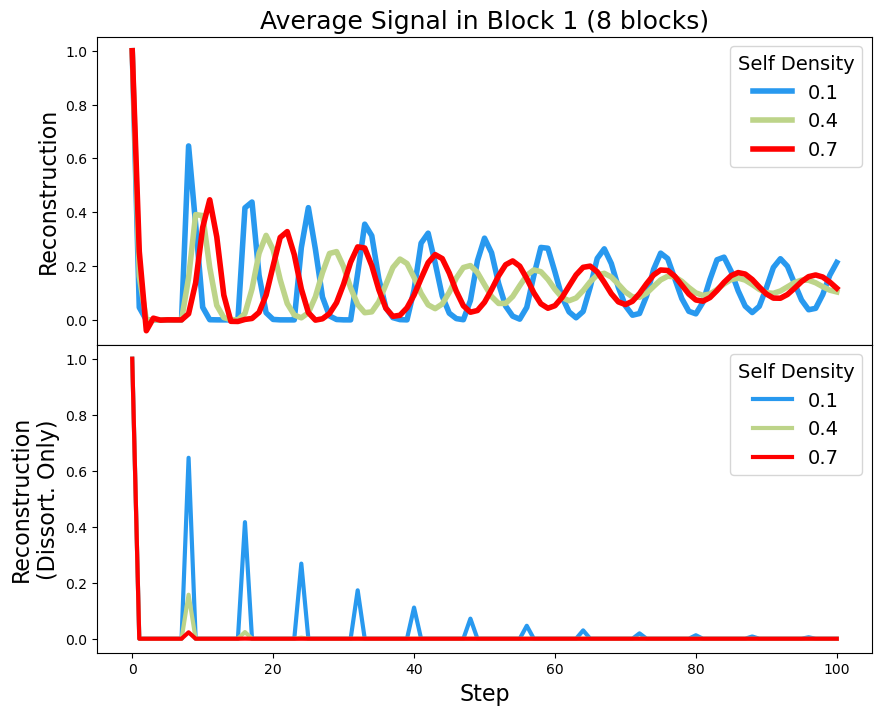

In [30]:
from matplotlib import animation
from ipywidgets import interact, widgets

%matplotlib inline

importlib.reload(dgsp)
importlib.reload(plot)

fig, all_axes = plt.subplots(nrows=2, figsize=(10, 8), gridspec_kw={"hspace": 0, "wspace": 0.1})

n_blocks = 8
connect_density = 1
use_uvt = False

all_self = [0.1, 0.4, 0.7]
cmap = cmap_8clusters.resampled(len(all_self)+1)

for com_i, com_density in enumerate(all_self):
    circular_pos, graph_pos = plot.circular_layout(n_blocks, n_per_com, radius=2, small_radius=0.3, return_dict=True)

    adj = dgsp_graphs.block_cycle(n_per_com, n_blocks=n_blocks, com_density=com_density, connect_density=connect_density, seed=28)
    n_nodes = len(adj)

    xt = np.zeros(n_nodes)
    xt[:n_per_com] += 1
    # xt[:n_per_com//2] += 1
    # xt[n_per_com:2*n_per_com] += 1
    # xt[3*n_per_com:] += 1

    U, S, Vh = dgsp.sorted_SVD(dgsp.modularity_matrix(adj), fix_negative=False)
    V = Vh.T

    n_kmeans = n_blocks * 2
    if (com_density == 0) or (connect_density == 0):
        n_kmeans = n_blocks

    C_mat_out, c_pinv_out, C_mat_in, c_pinv_in, bimod_idx = dgsp.get_c_pinv(adj, all_nvecs[n], n_kmeans, normalize=False)

    all_rec = np.zeros((2, n_trials+1, n_nodes))
    all_rec_sing = np.zeros((2, n_trials+1, n_nodes))

    c_pinv_in_high = c_pinv_in.copy()
    c_pinv_in_high[n_kmeans//2:] = 0

    c_pinv_in_low = c_pinv_in.copy()
    c_pinv_in_low[:n_kmeans//2] = 0

    all_rec_high = np.zeros((n_trials+1, n_nodes))
    all_rec_low = np.zeros((n_trials+1, n_nodes))

    all_rec_high[0] = xt
    all_rec_low[0] = xt

    all_rec[0, 0] = xt
    all_rec[1, 0] = xt

    all_rec_sing[0, 0] = xt
    all_rec_sing[1, 0] = xt

    for i in range(n_trials):
        coefs_in = c_pinv_in @ all_rec[0, i]
        coefs_out = c_pinv_out @ all_rec[1, i]

        c_high = c_pinv_in_high @ all_rec_high[i]
        c_low = c_pinv_in_low @ all_rec_low[i]

        all_rec_high[i+1] = C_mat_out @ c_high
        all_rec_low[i+1] = C_mat_out @ c_low
        
        all_rec[0, i+1] = C_mat_out @ coefs_in
        all_rec[1, i+1] = C_mat_in @ coefs_out

        all_rec_sing[0, i+1] = U @ (V.T @ all_rec_sing[0, i])
        all_rec_sing[1, i+1] = V @ (U.T @ all_rec_sing[1, i])

    if use_uvt:
        rec_to_use = all_rec_sing
    else:
        rec_to_use = all_rec
    
    plot_sig = rec_to_use[0, :, :n_per_com].mean(axis=-1)
    all_axes[0].plot(plot_sig, lw=4, color=cmap(com_i+1), label=f"{com_density:.1f}")
    
    all_axes[1].plot(all_rec_high[:, :n_per_com].mean(axis=-1), lw=3, color=cmap(com_i+1), label=f"{com_density:.1f}")
    # all_axes[ax_i].plot(all_rec_low[:, :n_per_com].mean(axis=-1), lw=1, ls=":", color=cmap(com_i+1), alpha=0.5, zorder=2)

for i, ylab in enumerate(["Reconstruction", "Reconstruction\n(Dissort. Only)"]):
    all_axes[i].legend(title="Self Density", loc="upper right", fontsize=14, title_fontsize=14)
    all_axes[i].set_ylabel(ylab, fontsize=16)

all_axes[0].set_title(f"Average Signal in Block 1 ({n_blocks} blocks)", fontsize=18)
all_axes[-1].set_xlabel("Step", fontsize=16)